In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

folder_path = '.'
image_file_name = '/images_75.npy'
label_file_name = '/labels_75.npy'

images = np.load(folder_path+image_file_name)
images = np.expand_dims(images, axis=-1)
labels = np.load(folder_path+label_file_name)

def shuffle_in_unison(a, b):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for shuffling in unison')
    p = np.random.permutation(len(a))
    return a[p], b[p]

images, labels = shuffle_in_unison(images,labels)

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-11-05 22:31:50.304514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 22:31:50.316486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762378310.325268 1263443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762378310.327788 1263443 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762378310.334904 1263443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def train_test_valid_split(a,b,train=0.8,test=0.1,valid=0.1,shuffle=True,check_data = False):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for splitting in unison')
    total_percentage = train + test + valid
    if total_percentage != 1:
        raise ValueError(f'''Data will not be split correctly \n 
        Total percentage of data used :{total_percentage*100}% \n 
        Training = {train*100}%, testing = {test*100}%, validation = {valid*100}%''')
    if shuffle == True:
        a, b = shuffle_in_unison(a,b)
    
    train_idx = int(len(a)*train)
    test_idx = train_idx+int(len(a)*test)
    valid_idx = len(a)
    train_x = a[:train_idx]
    test_x = a[train_idx:test_idx]
    valid_x = a[test_idx:]
    train_y = b[:train_idx]
    test_y = b[train_idx:test_idx]
    valid_y = b[test_idx:]

    
    if check_data:
        check_len_match = len(train_x) + len(test_x) + len(valid_x)
        print(f'Size of train, test and valid: {len(train_x)},{len(test_x)},{len(valid_x)}')
        if check_len_match == len(a):
            print('yippee')
        else:
            print('no:(')
    
    return train_x, train_y, test_x, test_y, valid_x, valid_y

In [3]:
def check_random_sample(a,b):
    rand_int=np.random.randint(0,len(a))
    plt.imshow(a[rand_int],cmap='gray')
    plt.show()
    if isinstance(b, list):
        hour_label = np.argmax(b[0][rand_int])
        minute_label = np.clip(b[1][rand_int] * 59, 0, 59).astype(int)
        print(f"Hour: {hour_label}, Minute: {minute_label[0]}")
        
    else:
        print(np.argmax(b[rand_int]))

[[0.94915254]
 [0.74576271]
 [0.10169492]
 ...
 [0.62711864]
 [0.06779661]
 [0.59322034]] [[0.6440678 ]
 [0.61016949]
 [0.47457627]
 ...
 [0.40677966]
 [0.66101695]
 [0.01694915]]


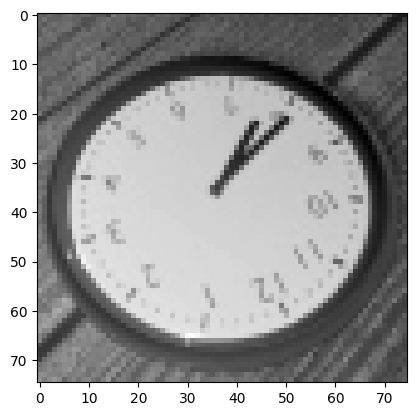

Hour: 7, Minute: 40


In [4]:
from tensorflow.keras.utils import to_categorical
scaler = MinMaxScaler(feature_range=(0, 1))
train_x, train_y, test_x, test_y, valid_x, valid_y = train_test_valid_split(images, labels)

train_x = train_x.astype('float32') / 255.0
valid_x = valid_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

hour_train = to_categorical(train_y[:, 0], num_classes=12)
minute_train = scaler.fit_transform(train_y[:,1].reshape(-1, 1))

hour_valid = to_categorical(valid_y[:, 0], num_classes=12)
minute_valid = scaler.transform(valid_y[:,1].reshape(-1, 1))

print(minute_train,minute_valid)

train_y=[hour_train,minute_train]
valid_y=[hour_valid,minute_valid]

check_random_sample(train_x,train_y)

In [5]:
# Can use data augmentation to increase the training data set size ie by concatentating a dataset that contatins all the flipped images
# Could also augmentent the data so that all images are alligned in the same direction to remove noise but this may make the model perform worse generally

In [6]:
train_input_dim = (75, 75, 1)
num_hour_classes = 12
print(train_y)
print(num_hour_classes)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0.94915254],
       [0.74576271],
       [0.10169492],
       ...,
       [0.62711864],
       [0.06779661],
       [0.59322034]])]
12


In [ ]:
import os
import datetime
if os.path.isdir("logs"):
    print('directory exists')
else:
    os.mkdir('./logs')
    os.mkdir('./logs/fit')
if os.path.isdir('models'):
    print('model directory exists')
else:
    os.mkdir('./models')
if os.path.isdir('plots'):
    print('plot directory exists')
else:
    os.mkdir('./plots')
if os.path.isdir('history'):
    print('history directory exists')
else:
    os.mkdir('./history')


directory exists
model directory exists


In [8]:
from os import listdir
from os.path import isfile, join
def get_iter(path,file_prefix=None):

    files = [f for f in listdir(path) if isfile(join(path, f))]
    iterations = []
    if file_prefix is not None:
        files = [file for file in files if file_prefix in file]

    if not files:
        return 1

    for file in files:
        file = file.split(".", 1)[0]
        try:
            iteration = int(file.split("_")[-1])
            iterations.append(iteration)
        except ValueError:
            continue
    iterations.sort(reverse=True)
    return iterations[0] + 1

In [9]:
def cnn(input_image_shape=(75,75,1),hour_classes=12):
    
    inputs = Input(shape=input_image_shape)
    x = Conv2D(32, kernel_size=(3,3), strides= 1,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_image_shape,
                    kernel_initializer= 'he_normal')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None)(x)

    x = Conv2D(64, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal')(x)
    x = MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None)(x)

    x = Conv2D(128, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation= 'relu')(x)
    hour_output = Dense(hour_classes, activation= 'softmax',name='hour_output')(x)
    minute_output = Dense(1,activation='sigmoid',name='minute_output')(x)
    
    model = Model(inputs=inputs,outputs=[hour_output,minute_output])

    model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
            loss={"hour_output": "categorical_crossentropy",
                "minute_output": "mae"},
            loss_weights={"hour_output": 0.3,
                        "minute_output": 5.0},
            metrics={"hour_output": "accuracy",
                    "minute_output": "mae"}
                    )
    return model

In [ ]:
model = cnn(train_input_dim, num_hour_classes)

path = './models'
iteration = get_iter(path,file_prefix='model')

# training parameters
EPOCHS = 500
BATCH_SIZE = 128
image_height = 75
image_width = 75
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = f"./models/my_model_{iteration}.h5"

log_dir="./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback_list = [TensorBoard(log_dir=log_dir),
                 EarlyStopping(monitor='val_loss',
                               patience=30,
                               mode='auto',
                               start_from_epoch=40,
                               restore_best_weights=True)]
                #  ReduceLROnPlateau(monitor='val_loss',
                #                    patience=10,
                #                    mode='auto')]

train_num = train_x.shape[0]
valid_num = valid_x.shape[0]

# start training
history = model.fit(    train_x,
                        train_y,
                        epochs=EPOCHS,
                        validation_data=(valid_x, valid_y),
                        callbacks=callback_list,
                        verbose=1,
                        batch_size = BATCH_SIZE
)
# save the whole model
model.save(model_dir)

Epoch 1/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - hour_output_accuracy: 0.0812 - hour_output_loss: 3.5882 - loss: 6.9766 - minute_output_loss: 1.3236 - minute_output_mae: 1.3236 - val_hour_output_accuracy: 0.0800 - val_hour_output_loss: 2.5210 - val_loss: 1.5808 - val_minute_output_loss: 0.2656 - val_minute_output_mae: 0.2657
Epoch 2/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - hour_output_accuracy: 0.0807 - hour_output_loss: 2.4926 - loss: 1.5494 - minute_output_loss: 0.2600 - minute_output_mae: 0.2600 - val_hour_output_accuracy: 0.0789 - val_hour_output_loss: 2.4851 - val_loss: 1.4379 - val_minute_output_loss: 0.2376 - val_minute_output_mae: 0.2379
Epoch 3/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - hour_output_accuracy: 0.0871 - hour_output_loss: 2.4817 - loss: 1.4064 - minute_output_loss: 0.2316 - minute_output_mae: 0.2316 - val_hour_output_accuracy: 0.0878 - val_hour_output_loss: 2.4744 - val_loss: 1.2897 - val_minute_output_loss: 0.2086 - val_minute_output_mae: 0.2085
E

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 73, 73,    │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 36, 36,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 36, 36,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 17, 17,    │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 17, 17,    │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 17, 17,    │          0 │ conv2d_35[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 36992)     │          0 │ dropout_7[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │  4,735,104 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour_output (Dense) │ (None, 12)        │      1,548 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ minute_output       │ (None, 1)         │        129 │ dense_11[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,488,361 (55.27 MB)

 Trainable params: 4,829,453 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,658,908 (36.85 MB)

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanAbsoluteError, CategoricalAccuracy
custom_objects = {
    'mae': MeanAbsoluteError,
    "MeanAbsoluteError": MeanAbsoluteError,
    "CategoricalAccuracy": CategoricalAccuracy
}

model = load_model('./models/my_model_32.h5', custom_objects = custom_objects)

I0000 00:00:1762378467.932317 1263443 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [12]:
hour_pred,minute_pred = model.predict(test_x)
minute_pred = np.clip(minute_pred,0,1)
predictions = [hour_pred,minute_pred]


I0000 00:00:1762378471.373384 1265274 service.cc:152] XLA service 0x72b948004fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762378471.373400 1265274 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-11-05 22:34:31.377911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762378471.407118 1265274 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-05 22:34:31.640872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_59', 4 bytes spill stores, 4 bytes spill loads



40/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

I0000 00:00:1762378472.139444 1265274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-05 22:34:32.486161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_59', 12 bytes spill stores, 12 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


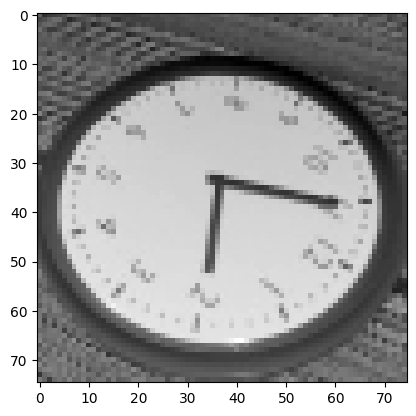

Hour: 1, Minute: 58


In [ ]:
check_random_sample(test_x,predictions)
hist_df = pd.DataFrame(history.history)
hist_path=f'./history/history{iteration}.csv'
with open(hist_path, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
def plot_history_loss(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/loss_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'loss_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_accuracy(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label]*100,'r-',label='Training') 
    plt.plot(history[second_label]*100,'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy (%)') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/accuracy_history_model_{iteration}.jpg' 
    else: savedir = savedir + 'accuracy_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_mae(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Mean absolute error') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/mae_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'mae_history_model_{iteration}.jpg' 
    plt.savefig(savedir)
    plt.show() 

In [ ]:
plot_history_accuracy(hist_df,'hour_output_categorical_accuracy','val_hour_output_categorical_accuracy','Accuracy history')
plot_history_loss(hist_df,'loss','val_loss','Loss history')
plot_history_mae(hist_df,'minute_output_mean_absolute_error','val_minute_output_mean_absolute_error','MAE history')


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score

def plot_predictions(predictions, true_values, savedir = None):
    if savedir is None: 
        savedir = f'./plots/predictions_for_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'predictions_for_model_{iteration}.jpg' 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    axes = axes.flatten()
    fig.suptitle('Predictive Power of the Model')

    hours_true, minutes_true = true_values[:,0], true_values[:,1]
    hours_pred, minutes_pred = tf.argmax(predictions[0], axis=1), predictions[1].flatten()

    cm = confusion_matrix(hours_true, hours_pred)
    acc = accuracy_score(hours_true, hours_pred)
    mae = mean_absolute_error(minutes_true, minutes_pred)
    mse = mean_squared_error(minutes_true, minutes_pred)
    r2 = r2_score(minutes_true, minute_pred)

    im = axes[0].imshow(cm, cmap='jet')
    axes[0].set_title(f'Hour Confusion Matrix\nAccuracy = {acc*100:.1f}')
    axes[0].set_xlabel('Predicted hours')
    axes[0].set_ylabel('True hours')
    fig.colorbar(im, ax=axes[0])

    h = axes[1].hist2d(minutes_true, minutes_pred, bins=60, density=False, cmap='jet')
    fig.colorbar(h[3], ax=axes[1])

    axes[1].plot([0, 59], [0, 59], 'k--',lw=3, label='Perfect Prediction')
    axes[1].set_title(f'Minute Prediction 2D Histogram\nMAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.3f}')
    axes[1].set_xlabel('Actual Minute')
    axes[1].set_ylabel('Predicted Minute')
    axes[1].legend()

    plt.savefig(savedir)
    plt.show()
    